In [1]:
#load the libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, alexnet
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook as tqdm
import requests
import librosa
import numpy as np
import torchaudio
from transformers import HubertForCTC, Wav2Vec2Processor

In [ ]:
#define the model and processor

processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")

def load_hubert_ctc():

    model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    # setting the model to evaluation mode
    model.eval()

    return model

In [3]:
# get the output before the final layer
def extract_features(model, input_values):

    waveform = input_values.to(model.device)

    # forward pass to get the features from an intermediate layer
    with torch.no_grad():

        # extract features from the last layer just before the CTC head
        features = model.hubert(waveform).last_hidden_state

    return features

In [ ]:
##load the file and begin pipeline

audio_input, original_sample_rate = torchaudio.load("/content/Sister haha.wav")

# check to see if the audio is stereo
if audio_input.shape[0] == 2:
    audio_input = torch.mean(audio_input, dim=0)

# normalizing the audio to be in the range [-1, 1]
audio_input = audio_input / audio_input.abs().max()

# resample the audio to 16 kHz sinbce HUBERT is trained on 16KHz
audio_input_resampled = torchaudio.transforms.Resample(orig_freq=original_sample_rate, new_freq=16000)(audio_input)

#process the audio
input_values = processor(audio_input_resampled, return_tensors="pt").input_values
input_values = input_values.to("cuda")
model = load_hubert_ctc().to("cuda")

In [5]:
input_values.shape

torch.Size([1, 1, 122192])

In [6]:
input_values= input_values.view(1, -1)
features=extract_features(model,input_values)

In [7]:
input_values.shape

torch.Size([1, 122192])

In [8]:
features.shape

torch.Size([1, 381, 1024])

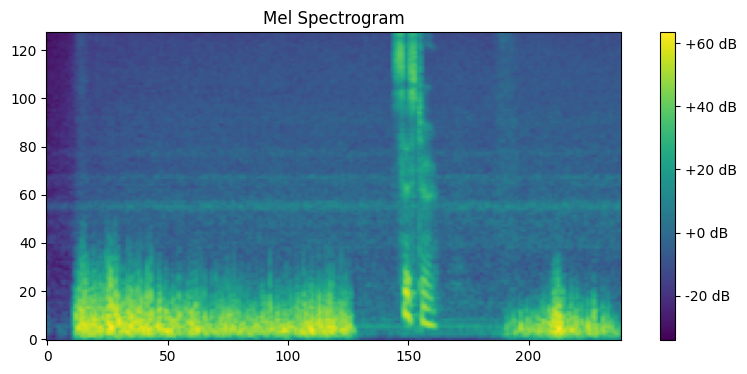

In [9]:
#visualization of input
import torch
import torchaudio
import matplotlib.pyplot as plt


def plot_mel_spectrogram(audio_tensor, sample_rate):

    audio_tensor = audio_tensor.to('cuda')

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to('cuda')


    mel_spec = mel_spectrogram(audio_tensor)

    # decibels
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)


    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec_db[0].cpu().detach().numpy(), cmap='viridis',origin='lower')
    plt.title("Mel Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    plt.show()
audio_tensor=input_values
plot_mel_spectrogram(audio_tensor, sample_rate=16000)

In [17]:
#frequency filtering using band pass filter and time filtering using Hamming window
import torch
import torchaudio.functional as F

def bandpass_filter(signal, low_freq, high_freq, sample_rate, order=2):# order can be tuned to sharpen the frequency bandwidth

    for _ in range(order):

        signal = F.highpass_biquad(signal, sample_rate, low_freq)
        signal = F.lowpass_biquad(signal, sample_rate, high_freq)
    return signal

def filter_signal(signal, sample_rate, bandwidth, num_time_frames):

    signal_length = signal.shape[-1]
    filtered_signals = []

    # window size for each time frame
    window_size = signal_length // num_time_frames


    for i in range(0, sample_rate // 2, bandwidth):
        low_freq = max(i, 0)  # make sure low frequency is not negative
        high_freq = min(i + bandwidth, sample_rate // 2)  # Nyquist frequency
        filtered_signal = bandpass_filter(signal, low_freq, high_freq, sample_rate)

        # Hamming windowing
        for j in range(num_time_frames):
            start = j * window_size
            end = min(start + window_size, signal_length)
            hamming_window = torch.hamming_window(window_size, periodic=False)
            window = torch.zeros(signal_length)
            window[start:end] = hamming_window


            windowed_signal = filtered_signal * window
            filtered_signals.append(windowed_signal.unsqueeze(0))

    # combine all filtered signals into a single tensor
    combined_signals = torch.cat(filtered_signals, dim=0)
    return combined_signals


bandwidth = 10 # set bandwidth for range of freq - of 50 Hz
num_time_frames = 4 # number of time frames for windowing


filtered_signals = filter_signal(audio_input_resampled, 16000, bandwidth, num_time_frames)

In [18]:
print(len(filtered_signals))

3200


In [19]:
#calculate cosine similarity scores
import torch.nn.functional as F

def calculate_cosine_similarities(model, original_signal, filtered_segments):

    original_features = extract_features(model, original_signal.unsqueeze(0) if original_signal.ndim == 1 else original_signal)
    # averaging features over time
    original_features = original_features.mean(dim=1)


    similarity_scores = []

    # loop tp get cosine similarity for each filtered segment
    for segment in filtered_segments:
        # extract features
        segment_features = extract_features(model, segment.unsqueeze(0) if segment.ndim == 1 else segment)
        segment_features = segment_features.mean(dim=1)

        # scaled to [0, 10]
        similarity = F.cosine_similarity(original_features, segment_features, dim=1).mean().item()
        scaled_similarity = (similarity + 1) * 5  # Scaling

        similarity_scores.append(scaled_similarity)

    return similarity_scores


cosine_similarities = calculate_cosine_similarities(model, audio_input_resampled, filtered_signals)

In [20]:
#inverse of cosine scores to be used as weights for visualization

import matplotlib.pyplot as plt
import torchaudio.transforms as T

def invert_cosine_scores(cosine_scores):

    max_score = max(cosine_scores)
    inverted_scores = [max_score - score for score in cosine_scores]
    return inverted_scores

def combine_signals_weighted(filtered_signals, weights):

    combined_signal = torch.zeros_like(filtered_signals[0])
    for signal, weight in zip(filtered_signals, weights):
        combined_signal += signal * weight
    return combined_signal


inverted_scores = invert_cosine_scores(cosine_similarities)
combined_signal = combine_signals_weighted(filtered_signals, inverted_scores)



In [ ]:
#run only to visualize filtered segments with the code below
#combined_signal=filtered_signals[182]

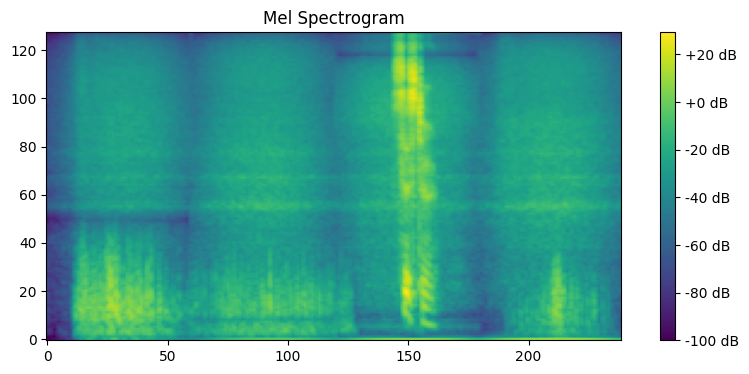

In [21]:
#visualization of results
audio_tensor=combined_signal
plot_mel_spectrogram(audio_tensor, sample_rate=16000)